In [363]:
import sys
sys.path.insert(0, "../")

import jax
import jax.numpy as jnp

import jax.scipy
import jax.scipy.special

from tqdm import tqdm
from functools import partial

import module.samplers
import module.hamiltonians
import module.wavefunctions

import flax.linen as nn

import optax
import numpy as np
from matplotlib import pyplot as plt

In [364]:
key = jax.random.PRNGKey(0)

In [365]:
def getLine(phi, theta, r_max = 10):
    r = jnp.linspace(-r_max, r_max, num = 2000)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

In [392]:
class Ansatz(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__(input_shape = (1,))

    def init_param(self, key):
        return jnp.array([0.,1.])
    
    def calc_logpsi(self, parameters, x):
        a = -0.5*jnp.log(2*jnp.pi)  -(x-parameters[0])**2*parameters[1]**2/2
        return jnp.squeeze(a/2)

In [393]:
ansatz = Ansatz()
key, _ = jax.random.split(key)
param = ansatz.init_param(key)

In [396]:
param = jnp.array([0,2])

0.49950007


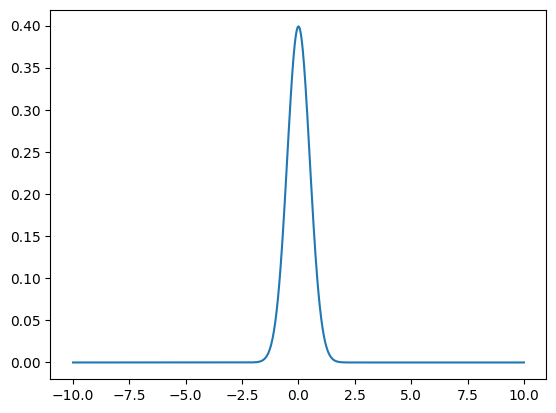

In [397]:
r = jnp.linspace(-10,10, num = 1000)
line = jnp.expand_dims(r, axis= 1)
psi = ansatz.calc_logpsi(param, line)

plt.plot(r, jnp.exp(psi)**2, label = "Ansatz")

print(jnp.sum(jnp.exp(psi)**2)*20/1000)

In [398]:
sampler = module.samplers.MCMCsimple(ansatz, 0.5)

In [399]:
subsampling = 20

In [400]:
def get_samples(N):
    """
    Returns decorrelated samples.
    """
    samples, ratio = sampler.sample(key, param, jax.random.normal(key, shape = (1,)) + param[0], N*subsampling)
    return samples[0:-1:subsampling], ratio

In [401]:
def eval_S1(orbital, parameters, samples, v):
    f = lambda param: orbital.calc_logpsi(param, samples)
    N = samples.shape[0]
    a = jax.jvp(f, (parameters,), (v,))[1]
    b = jax.vjp(f, parameters)[1](a)[0]
    return 1/N * b

def eval_S2(orbital, parameters, samples, v):
    f = lambda param: orbital.calc_logpsi(param, samples)
    N = samples.shape[0]
    e = jnp.ones(N)
    a = jnp.sum(jax.jvp(f, (parameters,), (v,))[1])
    b = jax.vjp(f, parameters)[1](e)[0]
    return  1/N**2 * a * b

@partial(jax.jit, static_argnames=['orbital'])
def eval_S(orbital, parameters, samples, v):
    s1 = eval_S1(orbital, parameters, samples, v)
    s2 = eval_S2(orbital, parameters, samples, v)
    return s1 - s2

In [412]:
param = jnp.array([5., 0.5])
key, _ = jax.random.split(key)
samples, r = get_samples(300000)

In [413]:
jnp.stack((eval_S(ansatz, param, samples, jnp.array([1., 0.])), eval_S(ansatz, param, samples, jnp.array([0., 1.]))))

Array([[ 0.06253696, -0.00304098],
       [-0.00304098,  2.010976  ]], dtype=float32)

In [419]:
jnp.stack((eval_S2(ansatz, param, samples, jnp.array([1., 0.])), eval_S2(ansatz, param, samples, jnp.array([0., 1.]))))

Array([[ 6.9540431e-07, -8.3441153e-04],
       [-8.3441148e-04,  1.0012053e+00]], dtype=float32)

In [416]:
3/4*(1/0.5)**2

3.0

In [418]:
jnp.stack((eval_S1(ansatz, param, samples, jnp.array([1., 0.])), eval_S1(ansatz, param, samples, jnp.array([0., 1.]))))

Array([[ 0.06253766, -0.00387539],
       [-0.00387539,  3.0121815 ]], dtype=float32)